# Sharding Results

Here we will analyze the results from [Hyperledger Caliper](https://hyperledger.github.io/caliper), showing the relation between shards and various workloads

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Default
import os
import re
import warnings

# File Utils
import glob
from bs4 import BeautifulSoup

# Processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read report data

In [4]:
def report_files(reports_dir: str, benchmark_name: str):
    return glob.glob(f"{reports_dir}/{benchmark_name}/*")

In [7]:
def parse_filename(pattern: str, filename: str, default: str):
    rs = re.search(pattern, filename)
    if rs:
        return rs.group(1) if rs.groups() else rs.group()
    return default

def parse_report_metrics(report_filename: str):
    with open(report_filename) as file:
        report = file.read()
        soup_report = BeautifulSoup(report)

        soup_tables = soup_report.find_all("table")
        if not soup_tables:
            warnings.warn(f"Table not found for file: '{file.name}'")

        soup_table = soup_tables[0]
        soup_headers = soup_table.find_all("th")
        soup_data = soup_table.find_all("td")

        headers = np.array([th.text.strip() for th in soup_headers])
        data = np.array([td.text.strip() for td in soup_data]).reshape((-1, len(headers)))
        
        df_report = pd.DataFrame(data, columns=headers)
        df_report["file"] = os.path.basename(report_filename)
        df_report["shards"] = df_report["file"].apply(lambda x: parse_filename(r"shards(\d+)", x, "1"))
        df_report["txcnt"] = df_report["file"].apply(lambda x: parse_filename(r"txcnt(\d+)", x, "50"))
        df_report["workers"] = df_report["file"].apply(lambda x: parse_filename(r"workers(\d+)", x, "2"))
        df_report["tps"] = df_report["file"].apply(lambda x: parse_filename(r"tps(\d+)", x, "200"))

        return df_report.apply(pd.to_numeric, errors="ignore")

In [9]:
reports_path = "../../../caliper-tests/reports"
reports_benchmark = "model-creation"

report_filenames = report_files(reports_dir=reports_path, benchmark_name=reports_benchmark)
reports = []
for filename in report_filenames:
    df_report = parse_report_metrics(filename)
    reports.append(df_report)

df_reports = pd.concat(reports).sort_values("file").reset_index(drop=True)
df_reports

,Name,Succ,Fail,Send Rate (TPS),Max Latency (s),Min Latency (s),Avg Latency (s),Throughput (TPS),file,shards,txcnt,workers,tps
0,Create models simulating 1 shards training,200,0,6.1,20.63,1.34,10.90,3.8,report_shards1.html,1,50,2,200
1,Create models simulating 2 shards training,200,0,9.1,6.32,0.98,3.57,7.2,report_shards2.html,2,50,2,200
2,Create models simulating 3 shards training,200,0,12.1,3.18,0.83,1.95,10.3,report_shards3.html,3,50,2,200
3,Create models simulating 4 shards training,200,0,15.2,2.52,0.69,1.59,12.7,report_shards4.html,4,50,2,200
4,Create models simulating 5 shards training,200,0,18.2,2.88,0.43,1.65,14.5,report_shards5.html,5,50,2,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,Create models simulating 4 shards training,45,0,18.6,4.50,2.00,2.52,6.9,report_workers9_shards4.html,4,50,9,200
1100,Create models simulating 5 shards training,45,0,22.4,4.52,2.33,2.66,6.9,report_workers9_shards5.html,5,50,9,200
1101,Create models simulating 6 shards training,45,0,26.0,4.50,2.33,2.65,7.2,report_workers9_shards6.html,6,50,9,200
1102,Create models simulating 7 shards training,45,0,29.8,4.55,2.35,2.57,7.6,report_workers9_shards7.html,7,50,9,200


## Throughput (TPS)

In [10]:
# Plot theming
sns.set_theme("paper")

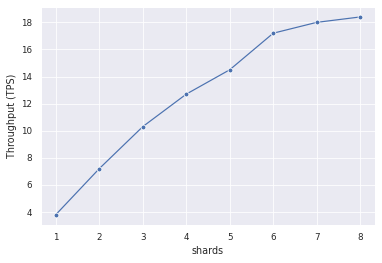

In [23]:
df_data =  df_reports[:8]
ax = sns.lineplot(
    data=df_data, 
    x="shards", 
    y="Throughput (TPS)", 
    marker="o",
    palette=sns.color_palette("hls", as_cmap=True)
)
ax.get_figure().savefig("shards-by-throughput.png", dpi=300)

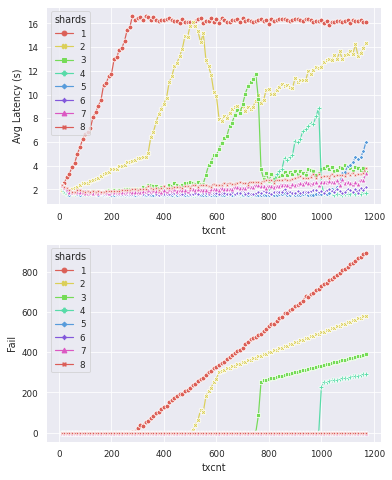

In [24]:
df_data = df_reports[df_reports["file"].str.contains("txcnt")]
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
ax = sns.lineplot(
    data=df_data, 
    x="txcnt", 
    y="Avg Latency (s)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[0]
)
ax = sns.lineplot(
    data=df_data, 
    x="txcnt", 
    y="Fail", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[1]
)
ax.get_figure().savefig("txcnt-by-fail-avglatency.png", dpi=300)

In [35]:
df_data = df_reports[(df_reports["file"].str.contains("txcnt")) & (df_reports["shards"] == 2)].sort_values("txcnt")
print(df_data.to_string())

                                            Name  Succ  Fail  Send Rate (TPS)  Max Latency (s)  Min Latency (s)  Avg Latency (s)  Throughput (TPS)                           file  shards  txcnt  workers  tps
177   Create models simulating 2 shards training    10     0             11.3             2.34             1.45             1.98               3.9    report_txcnt10_shards2.html       2     10        2  200
329   Create models simulating 2 shards training    20     0             10.0             2.81             0.55             1.75               4.4    report_txcnt20_shards2.html       2     20        2  200
417   Create models simulating 2 shards training    30     0              9.7             2.80             0.57             1.82               6.5    report_txcnt30_shards2.html       2     30        2  200
505   Create models simulating 2 shards training    40     0              9.5             3.00             0.55             1.92               5.9    report_txcnt40_shards2

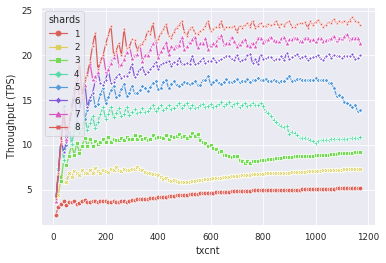

In [25]:
df_data = df_reports[df_reports["file"].str.contains("txcnt")]
ax = sns.lineplot(
    data=df_data, 
    x="txcnt", 
    y="Throughput (TPS)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True)
)
ax.get_figure().savefig("txcnt-by-throughput.png", dpi=300)

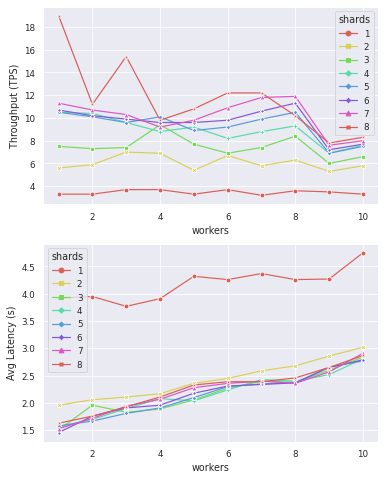

In [26]:
df_data = df_reports[df_reports["file"].str.contains("worker")]
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
ax = sns.lineplot(
    data=df_data, 
    x="workers", 
    y="Throughput (TPS)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[0]
)
ax = sns.lineplot(
    data=df_data, 
    x="workers", 
    y="Avg Latency (s)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[1]
)
ax.get_figure().savefig("workers-by-throughput-avglatency.png", dpi=300)

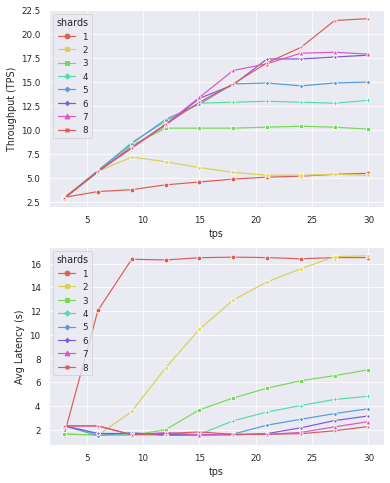

In [27]:
df_data = df_reports[df_reports["file"].str.contains("tps")]
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
ax = sns.lineplot(
    data=df_data, 
    x="tps", 
    y="Throughput (TPS)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[0]
)
ax = sns.lineplot(
    data=df_data, 
    x="tps", 
    y="Avg Latency (s)", 
    hue="shards",  
    style="shards", 
    markers=True, dashes=False,
    legend=df_data.shards.unique().tolist(), 
    palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[1]
)
ax.get_figure().savefig("tps-by-throughput-avglatency.png", dpi=300)